# 13. Model Interpretability (SHAP Analysis)

## Objective
Understand *why* the XGBoost model makes specific predictions using SHAP (SHapley Additive exPlanations) values.

## Inputs
- `trajectory_ml_ready_advanced.csv`

## Analysis Steps
1.  **Retrain Best Model**: Use the optimized hyperparameters found in Step 11.
2.  **Global Importance**: Summary plot of feature impact.
3.  **Local Interpretability**: Explain individual predictions (e.g., why was School X predicted to Decline?).
4.  **Dependence Plots**: Visualize non-linear relationships.

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# Set plot style
sns.set(style="whitegrid")
shap.initjs()

## 1. Load Data & Retrain Model

In [13]:
df = pd.read_csv('../trajectory_ml_ready_advanced.csv')

# Drop identifiers
drop_cols = ['UNITID', 'Institution_Name', 'Year', 'Target_Trajectory', 'Target_Label', 'State']
X = df.drop(columns=drop_cols)
y = df['Target_Label']

# Encode categorical variables
X = pd.get_dummies(X, columns=['Division'], drop_first=True)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Apply SMOTE (only on training data)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Best Hyperparameters from Step 11
best_params = {
    'n_estimators': 300,
    'max_depth': 3,
    'learning_rate': 0.05,
    'subsample': 0.7,
    'colsample_bytree': 0.9,
    'min_child_weight': 3,
    'use_label_encoder': False,
    'eval_metric': 'mlogloss',
    'random_state': 42
}

model = XGBClassifier(**best_params)
model.fit(X_train_resampled, y_train_resampled)

print("Model Retrained Successfully.")

/Users/abnerlusung/PycharmProjects/PythonProject/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [21:57:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model Retrained Successfully.


## 2. Calculate SHAP Values

In [14]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(model)

# Calculate shap values. This is what we will plot.
# We'll use a sample of the test set to speed up calculation if needed, but here dataset is small enough.
shap_values = explainer.shap_values(X_test)

print(f"SHAP Values Shape: {np.array(shap_values).shape}")
# Shape should be (n_classes, n_samples, n_features)

SHAP Values Shape: (2411, 22, 3)


## 3. Global Feature Importance (Summary Plot)
This plot shows which features are most important for each class.
- Class 0: Declining
- Class 1: Stable
- Class 2: Improving

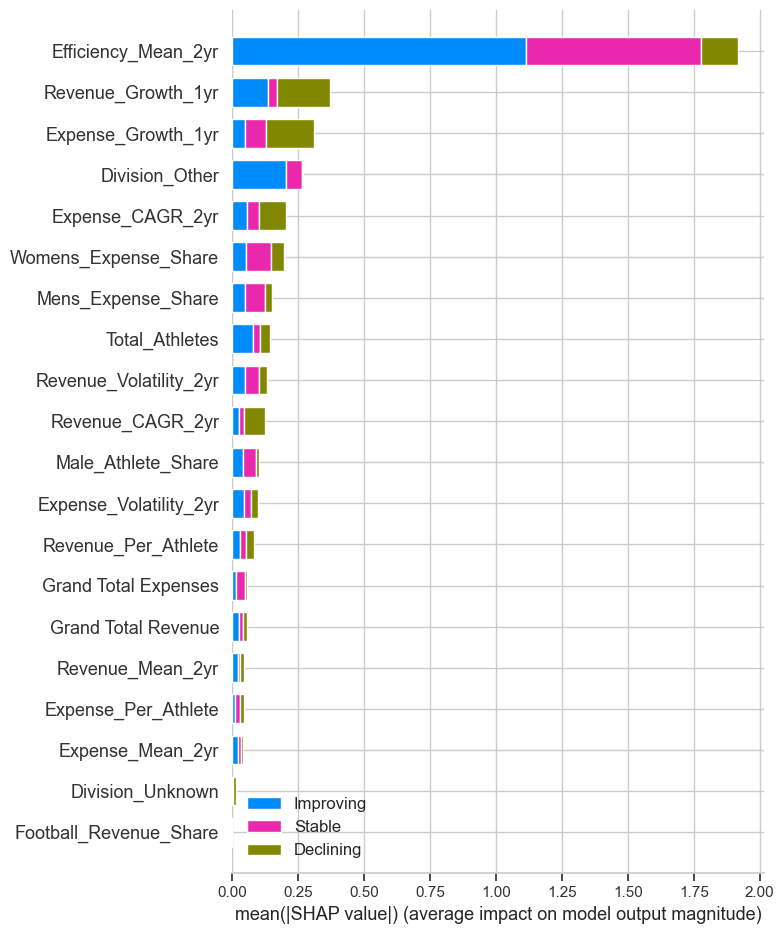

In [15]:
class_names = ['Declining', 'Stable', 'Improving']

# Summary plot for all classes
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test, class_names=class_names, plot_type="bar")

## 4. Detailed Summary Plot (Class 0: Declining)
Let's look specifically at what drives a school to be classified as **Declining**.

<Figure size 1200x800 with 0 Axes>

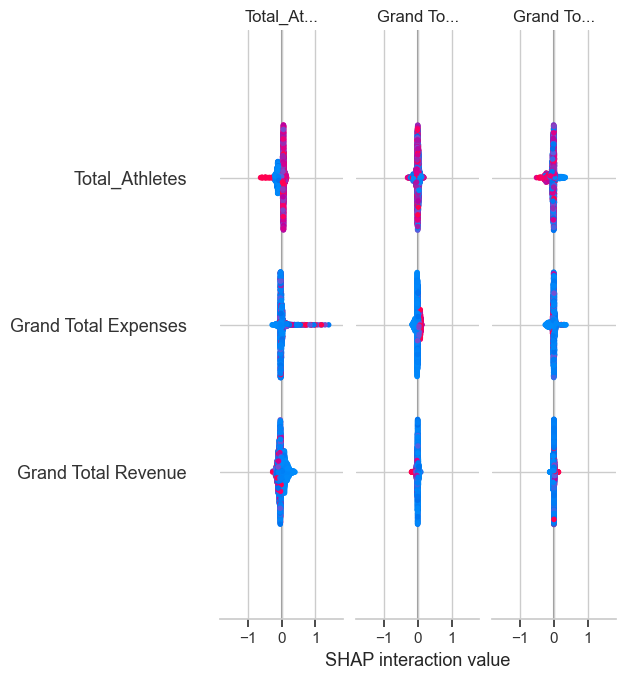

In [17]:
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test, plot_type="dot")

**Interpretation:**
- **High values** (red) of `Efficiency_Mean_2yr` (Revenue/Expense) have a **negative** impact on the "Declining" prediction (pushing it towards Stable/Improving).
- **Low values** (blue) of `Efficiency_Mean_2yr` increase the risk of Declining.
- This confirms our intuition: Inefficiency leads to decline.

## 5. Dependence Plot
Let's see the interaction between `Efficiency_Mean_2yr` and `Total_Athletes`.

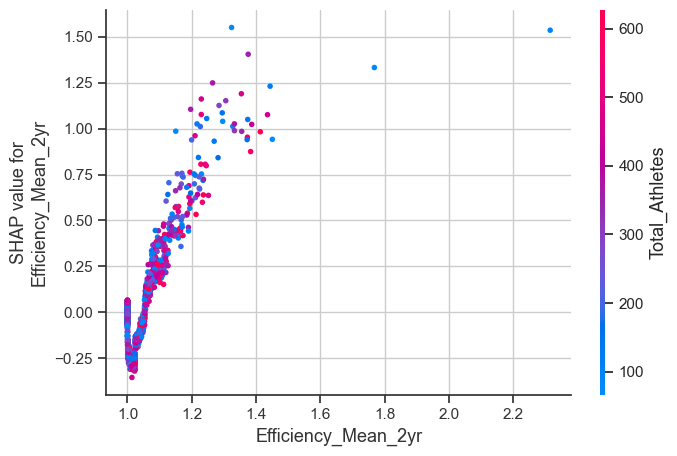

In [21]:
shap.dependence_plot("Efficiency_Mean_2yr", shap_values[:, :, 0], X_test, interaction_index="Total_Athletes")
